# HPCCG
---
## Parameters
```
Compiler = 'clang 5.0.1'
Build_Flags = '-g -O3 -march=native -ftree-vectorize -fopenmp'
Run_Flags = '256 256 256'
```

---
## Scaling

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

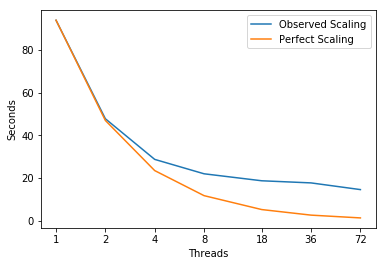

In [2]:
# Plot Measurements
Threads = [1,2,4,8,18,36,72]
fig, ax = plt.subplots(); ax.set_xscale('log', basex=2); ax.set_xticks(Threads)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.plot(Threads, [94.0, 47.8, 28.75, 22.0, 18.722222222222225, 17.722222222222225, 14.583333333333334],
        label='Observed Scaling')
ax.plot(Threads, [94.0, 47.0, 23.5, 11.75, 5.222222222222222, 2.611111111111111, 1.3055555555555556],
        label='Perfect Scaling')
ax.legend(); ax.set_xlabel('Threads'); ax.set_ylabel('Seconds')
plt.show()

---
## Roofline - Intel Haswell - 72 Threads - 36 Cores - 2 Sockets - 2301.0 Mhz
| GB/sec | L1 B/W | L2 B/W | L3 B/W | DRAM B/W |
|:---------|:------:|:------:|:------:|:--------:|
| **1 Thread**   | 142.7  |  45.0  |  33.7  |   16.0   |
|**72 Threads**  | 2399.9  |  784.0  |  564.8  |   60.4  |

---
## Program Aggregate
| Experiment Aggregate Metrics | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-------------------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1                              |  100.0 %   |        1.6          |         7.9% |         41.3% |     12.5% |                1.09     |       29.7% |       16.4%  |       4.3%    |
| 72                             |  100.0%   |       0.47          |         4.6% |         66.5% |     11.6% |                0.34     |       11.2% |       10.3%  |      11.1%    |



---
## HPC_sparsemv( )
| HPC_sparsemv | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-----------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1                |  81.4 %   |        1.6          |         8.0% |         38.6% |     11.9% |                1.16     |       31.2% |       16.1%  |       4.0%    |
| 72               |  65.4 %   |       0.45          |         8.9% |         66.3% |     10.4% |                0.24     |       15.0% |       13.8%  |      13.4%    |
```c
|66|int HPC_sparsemv( HPC_Sparse_Matrix *A,                  
|67|		 const double * const x, double * const y)
|68|{
|69|
|70|  const int nrow = (const int) A->local_nrow;
|71|
|72|#ifdef USING_OMP
|73|#pragma omp parallel for
|74|#endif
|75|  for (int i=0; i< nrow; i++)
|76|    {
|77|      double sum = 0.0;
|78|      const double * const cur_vals = 
|79|     (const double * const) A->ptr_to_vals_in_row[i];
|80|
|81|      const int    * const cur_inds = 
|82|     (const int    * const) A->ptr_to_inds_in_row[i];
|83|
|84|      const int cur_nnz = (const int) A->nnz_in_row[i];
|85|
|86|      for (int j=0; j< cur_nnz; j++)                    
```
| HPC_sparsemv.cpp: 87 | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:---------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1                    |  62.9 %   |        1.7          |         8.0% |         38.6% |     12.4% |                1.17     |       31.6% |       16.3%  |       4.3%    |
| 72                   |  56.2 %   |       0.44          |         8.9% |         66.5% |     10.8% |                0.23     |       14.0% |       12.9%  |      13.1%    |
```c
|87|        sum += cur_vals[j]*x[cur_inds[j]];             
|88|      y[i] = sum;
|89|    }
|90|  return(0);
|91|}
```

Time moved into Waxby?. TODO: Look into

### Memory Latency Bound by Nested Index:  `x[cur_inds[j]]`